## Tutorial 10, Question 1b

In [1]:
import os
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Create figures directory if it doesn't exist
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

creating the figures folder


In [2]:
# Define input patterns
X = torch.tensor([[[1, 1, 1],[0, 0, 0], [0, 0, 0]],
                  [[1, 0, 0],[1, 0, 0], [1, 0, 0]],
                  [[0, 0, 1],[0, 1, 0], [1, 0, 0]],
                  [[1, 0, 0],[0, 1, 0], [0, 0, 1]],
                  [[1, 0, 0], [1, 0, 0], [1, 1, 1]]], dtype=torch.float32)
X = X.reshape(5, 9)
print(X)

# Set the random seed for reproducibility
seed = 20
torch.manual_seed(seed)

tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 1., 1., 1.]])


# Defining an Autoencoder

In this section, we define a simple autoencoder. An autoencoder is a type of artificial neural network used to learn efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction.

## Class Definition: `Autoencoder`

The `Autoencoder` class inherits from `nn.Module` and customizes the building blocks of its neural network.

### Initialization Method: `__init__`

- **Parameters**:
    - `n_input` (int): The number of input neurons (dimension of the input data).
    - `n_hidden` (int): The number of neurons in the hidden layer. This parameter dictates the encoding dimension.

- **Attributes**:
    - `self.W` (Tensor): Weights for the input to hidden layer transformation, initialized with a standard normal distribution scaled by `1/sqrt(n_input)` for stability.
    - `self.b` (Tensor): Biases for the hidden layer, initialized as zeros.
    - `self.b_prime` (Tensor): Biases for the reconstruction layer, initialized as zeros.

### Forward Method: `forward`

- **Parameters**:
    - `x` (Tensor): The input data to the autoencoder.

- **Operations**:
    1. **Encoding**: Computes the hidden layer activations `h` using a sigmoid activation function. This represents the encoded input data.
    2. **Decoding**: Computes the reconstruction `y` from the hidden representation `h` using the transposed weights `self.W.t()` and adding the bias `self.b_prime`. The sigmoid activation function is applied to the output.
    3. **Binarization**: Produces a binary output `o` by applying a threshold of 0.5 to the reconstructed output `y`.

- **Returns**:
    - `y` (Tensor): The reconstructed data (decoded output).
    - `o` (Tensor): The binarized version of the reconstructed data.

## Creating an Instance of the Autoencoder

An instance of the `Autoencoder` class is created with `n_input=5` and `n_hidden=3`, specifying the dimensions of the input and the hidden layer, respectively.

```python
autoencoder = Autoencoder(n_input=9, n_hidden=4)


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(n_input, n_hidden) * np.sqrt(1. / n_input))
        self.W_prime = nn.Parameter(torch.randn(n_hidden, n_input) * np.sqrt(1. / n_input))
        self.b = nn.Parameter(torch.zeros(n_hidden))
        self.b_prime = nn.Parameter(torch.zeros(n_input))

    def forward(self, x):
        h = torch.sigmoid(torch.matmul(x, self.W) + self.b)
        y = torch.sigmoid(torch.matmul(h, self.W_prime) + self.b_prime)
        o = torch.where(y > 0.5, torch.ones_like(y), torch.zeros_like(y))
        return h, y, o

autoencoder = Autoencoder(n_input=9, n_hidden=4)

# Understanding the Training Code

In this section, we'll explain the PyTorch code used for training an autoencoder. We define the optimizer, the custom loss function, and the training function.

## Optimizer

The first part of the code defines the optimizer that we'll use for training:

```python
optimizer = optim.SGD(autoencoder.parameters(), lr=0.1)
```


## Loss Function for Binary Cross-Entropy and Bit Error

The code snippet defines a loss function that calculates two types of losses for a binary classification problem: the binary cross-entropy loss and the bit error loss.

### Binary Cross-Entropy Loss (`entropy_loss`):

- This loss measures the performance of a classification model whose output is a probability value between 0 and 1.
- The loss increases as the predicted probability diverges from the actual label.
- It is calculated using the formula: `-torch.mean(torch.sum(original * torch.log(y) + (1. - original) * torch.log(1. - y), dim=1))`
  - `original` is the true label (ground truth), and `y` is the predicted probability by the model.
  - The logarithmic function is applied to each predicted probability `y` and `1 - y`, which is then multiplied by the actual label `original` and `1 - original`, respectively.
  - The sum of these values is computed for each sample in the batch (`dim=1` indicates summation over the feature dimension).
  - The mean of these sums is taken across the batch to get the average loss.

### Bit Error Loss (`bit_loss`):

- This loss counts the number of bits that are different between the predicted output `o` and the actual label `original`.
- It is a simple count of how many predictions are exactly wrong, without considering the probability of the prediction.
- Calculated using `torch.sum(o != original).item()`, which computes the element-wise inequality between `o` and `original`, sums up all the `True` values (indicating a bit error), and converts the result to a Python scalar with `.item()`.

### Return Values:

- The function returns both `entropy_loss` and `bit_loss`.
- `entropy_loss` is the primary loss used for training the model, while `bit_loss` can be used as an additional metric to understand the model's performance in terms of exact bit matches.



In [4]:
# Define optimizer
optimizer = optim.SGD(autoencoder.parameters(), lr=0.1)

# Loss function
def loss(h, y, o, original):
    rho = 0.1

    # Calculate the binary entropy loss
    entropy_loss = -torch.mean(torch.sum(original * torch.log(y) + (1. - original) * torch.log(1. - y), dim=1))

    # Calculate the bit loss
    bit_loss = torch.sum(o != original).item()

    # Calculate the sparse loss
    mean_h = torch.mean(h, dim=0)
    sparse_loss = torch.sum(rho * torch.log(rho / mean_h) + (1 - rho) * torch.log((1 - rho) / (1 - mean_h)))

    return entropy_loss + 0.5 * sparse_loss, bit_loss

In [5]:
# Training function
def train(original):
    optimizer.zero_grad()  # Zero gradients
    h, y, o = autoencoder(original)  # Forward pass
    total_loss, bit_loss = loss(h, y, o, original)
    total_loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return total_loss.item(), bit_loss

In [6]:
# Training the model
epochs = 2000
l, bl = [], []
for i in range(epochs):
    l_, bl_ = train(X)
    l.append(l_)
    bl.append(bl_)
    if i % 100 == 0:
        print(f'epoch: {i}, total_loss: {l[i]}, bit_loss: {bl[i]}')

epoch: 0, total_loss: 7.288961410522461, bit_loss: 20
epoch: 100, total_loss: 4.670464038848877, bit_loss: 13
epoch: 200, total_loss: 3.838998317718506, bit_loss: 9
epoch: 300, total_loss: 3.3121423721313477, bit_loss: 9
epoch: 400, total_loss: 2.9855406284332275, bit_loss: 8
epoch: 500, total_loss: 2.734809398651123, bit_loss: 6
epoch: 600, total_loss: 2.4990780353546143, bit_loss: 2
epoch: 700, total_loss: 2.255580425262451, bit_loss: 2
epoch: 800, total_loss: 2.0357067584991455, bit_loss: 2
epoch: 900, total_loss: 1.8512351512908936, bit_loss: 2
epoch: 1000, total_loss: 1.6898020505905151, bit_loss: 2
epoch: 1100, total_loss: 1.541372537612915, bit_loss: 2
epoch: 1200, total_loss: 1.4028987884521484, bit_loss: 1
epoch: 1300, total_loss: 1.2749031782150269, bit_loss: 1
epoch: 1400, total_loss: 1.1588776111602783, bit_loss: 1
epoch: 1500, total_loss: 1.0559756755828857, bit_loss: 0
epoch: 1600, total_loss: 0.9665210843086243, bit_loss: 0
epoch: 1700, total_loss: 0.8898202180862427, bi

In [7]:
# Display weights and biases
print(f'W:\n {autoencoder.W.data}\n')
print(f'W_prime:\n {autoencoder.W_prime.data}\n')
print(f'b:\n {autoencoder.b.data}\n')
print(f'b_prime:\n {autoencoder.b_prime.data}\n')

W:
 tensor([[ 0.2693, -0.6963,  0.7908,  1.3101],
        [-0.8612, -0.7763,  2.1997, -0.2562],
        [-2.0359, -2.2188,  1.6613, -1.7386],
        [ 2.1135,  1.8982, -0.8923, -1.1621],
        [-2.6880, -2.7191, -2.8330,  0.7545],
        [ 0.0641,  0.3798,  0.0269, -0.2577],
        [ 1.0243,  0.4042, -0.9752, -3.5422],
        [-1.5969,  2.7576, -1.3955, -0.0790],
        [-1.9770,  1.5598, -2.8313,  2.1123]])

W_prime:
 tensor([[ 2.7544, -1.6692, -3.3834,  4.2995, -3.1130, -0.8501,  2.5228, -0.7688,
         -2.0668],
        [ 3.2955, -2.3571, -4.0995,  5.2586, -4.9278, -1.1138,  3.3158,  5.5399,
          3.4433],
        [ 2.4002,  5.8303,  5.0095, -2.9082, -4.7423, -1.2832, -3.0701, -3.7878,
         -5.6506],
        [ 3.7825, -0.9833, -3.6115, -1.7625,  1.6002, -1.0698, -4.3225, -0.7160,
          4.1070]])

b:
 tensor([-1.2380, -2.2536, -0.6383, -0.4749])

b_prime:
 tensor([-1.0660, -2.9856,  1.0981, -2.2263,  1.9893, -4.4020,  1.6365, -3.0606,
        -1.3419])



In [8]:
# Evaluate result of reconstruction
with torch.no_grad():
    h, y, o = autoencoder(X)
print(f'Input:\n {X}\n')
print(f'Hidden activation:\n {h}\n')
print(f'Output:\n {y}\n')
print(f'Output_binary:\n {o}\n')

Input:
 tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 1., 1., 1.]])

Hidden activation:
 tensor([[0.0205, 0.0026, 0.9823, 0.2388],
        [0.8974, 0.3436, 0.1525, 0.0205],
        [0.0071, 0.0011, 0.0581, 0.0067],
        [0.0036, 0.0162, 0.0040, 0.9759],
        [0.1971, 0.9752, 0.0026, 0.1375]])

Output:
 tensor([[9.0549e-01, 9.2173e-01, 9.9380e-01, 4.4885e-03, 8.5999e-02, 2.6298e-03,
         8.7004e-02, 9.5446e-04, 2.6120e-03],
        [9.5173e-01, 1.1840e-02, 6.5584e-02, 9.5070e-01, 3.9621e-02, 3.1252e-03,
         9.8883e-01, 8.0203e-02, 5.7781e-02],
        [2.9362e-01, 6.4900e-02, 7.9191e-01, 8.5439e-02, 8.4509e-01, 1.1085e-02,
         8.1012e-01, 3.6097e-02, 1.6060e-01],
        [9.3691e-01, 1.8599e-02, 7.6944e-02, 2.0678e-02, 9.6897e-01, 4.1843e-03,
         7.3666e-02, 2.4417e-02, 9.3653e-01],
        [9.

In [9]:
torch.mean(h)

tensor(0.2522)

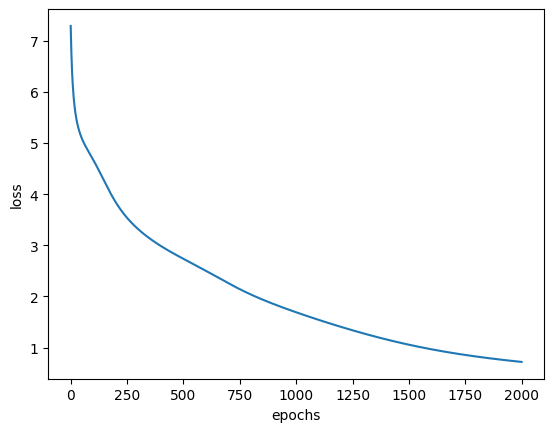

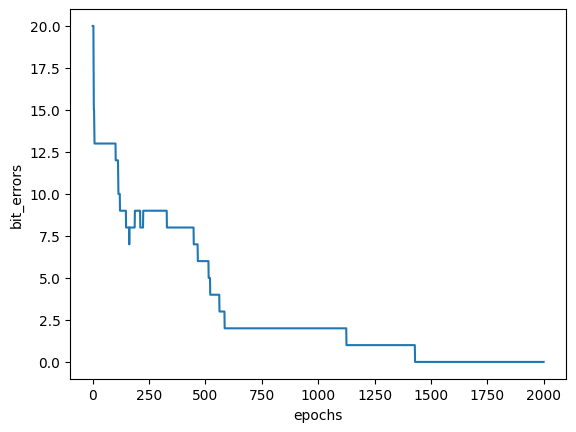

In [10]:
# Plot the results
pylab.figure()
pylab.plot(range(epochs), l)
pylab.xlabel('epochs')
pylab.ylabel('loss')
pylab.savefig('./figures/10.1_3.png')

pylab.figure()
pylab.plot(range(epochs), bl)
pylab.xlabel('epochs')
pylab.ylabel('bit_errors')
pylab.savefig('./figures/10.1_4.png')

pylab.show()